<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.version.VERSION)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [165]:
import urllib
coin = 'BTC'
with urllib.request.urlopen(f"http://www.cryptodatadownload.com/cdd/Coinbase_{coin}USD_1h.csv") as f:
    print(next(f))
    data = pd.read_csv(f)
data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d %I-%p')

b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'


In [0]:
data.index=data['Date']

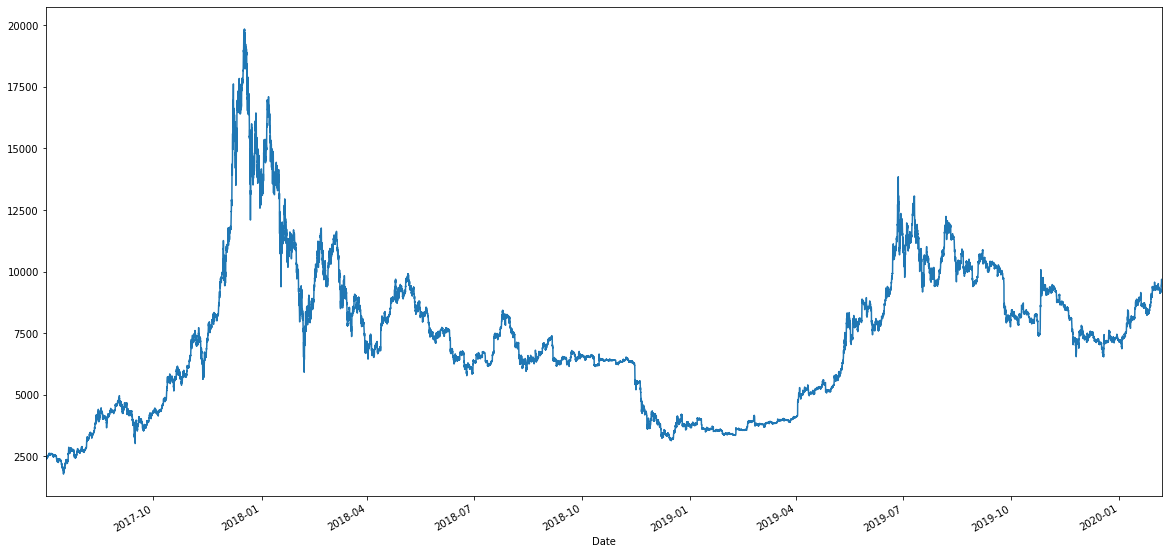

In [212]:
data['Close'].plot()

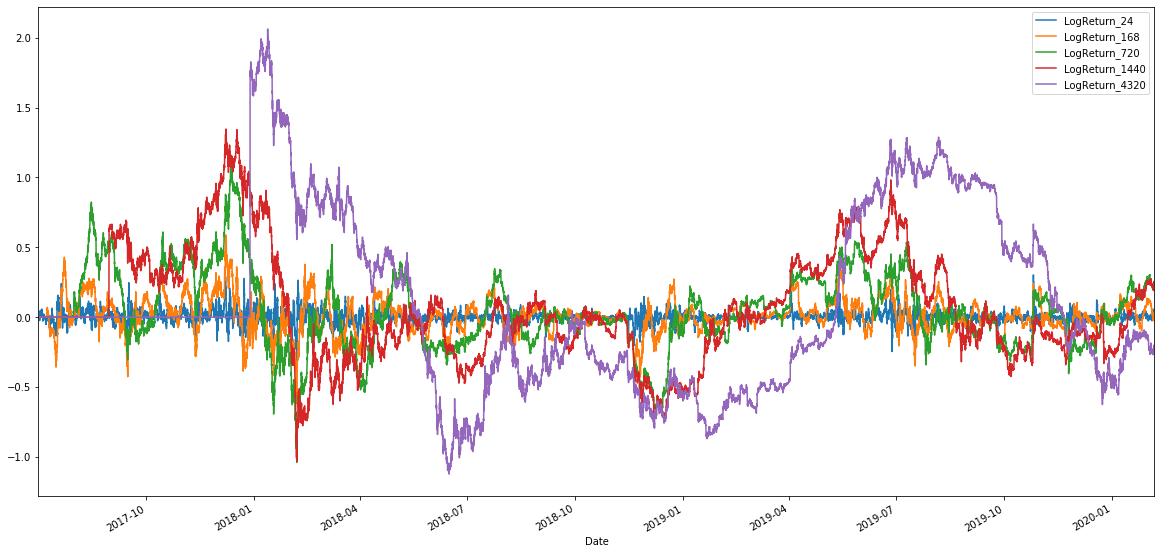

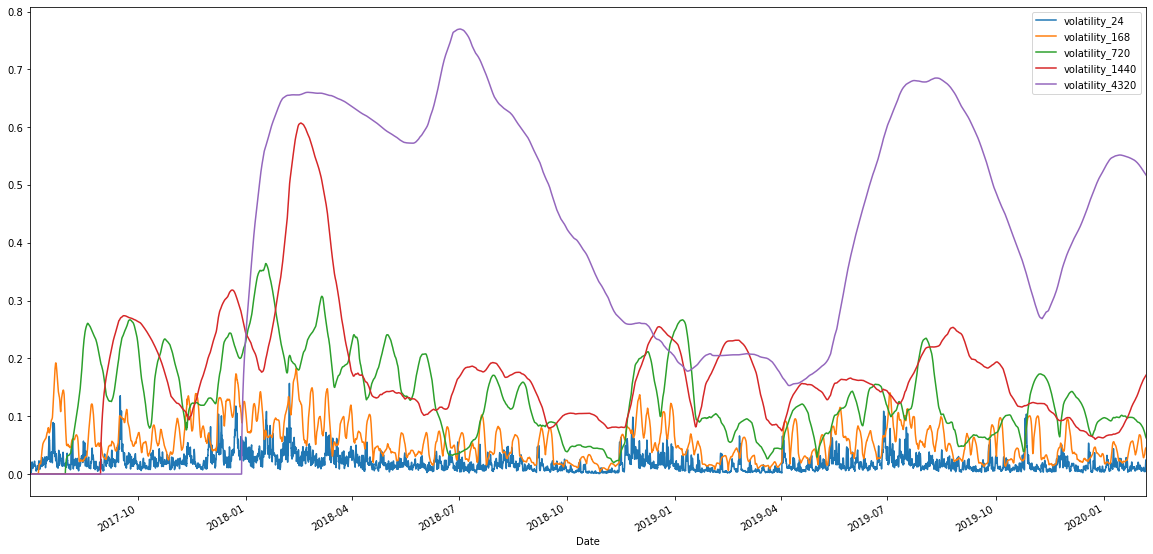

In [227]:
windows = [24, 7 * 24, 30 * 24, 60 * 24, 180 * 24]
for window in windows:
  logx = np.log(x)
  log_return = logx[:-window] - logx[window:]
  data.loc[:, f'LogReturn_{window}'] = np.append(log_return, [0]*window)
  data[f'LogReturn_{window}'].plot()
plt.legend()
plt.show()
for window in windows:
  volatility = np.std(np.vstack([data[f'LogReturn_{window}'].to_numpy()[i:i-window] for i in range(window)]), axis=0)
  data.loc[:, f'volatility_{window}'] = np.append(volatility, [0]*window)
  data[f'volatility_{window}'].plot()
plt.legend()
plt.show()